In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Basic HCM sampling

This notebook shows the HMC sampling method for a multivariate Gaussian distribution and compares the obtained samples to generated samples of the RWMH algorithm.


## Data

We will use 800 samples of a multivaraite Gaussian distribution with the following mean vector

\begin{equation}
\mu = \begin{pmatrix} 0 \\ 0\\ 0 \end{pmatrix}
\end{equation}

and covariance matrix 

\begin{equation}
\Sigma = \begin{pmatrix} 1.5 & 0.85 & 0.55 \\ 0.85 & 1.5 & -0.5 \\ 0.55 & -0.5 & 1.0 \end{pmatrix}
\end{equation}

In [2]:
μ = np.zeros(3)
Σ = np.array([[1.5,.85,0.55],[.85,1.5,-0.5],[0.55,-0.5,1.0]])
Y = pd.DataFrame(np.random.multivariate_normal(μ,Σ,size=800),columns=['x_1','x_2','x_3'])
Y.describe()

,x_1,x_2,x_3
count,800.000000,800.000000,800.000000
mean,-0.017733,0.029691,-0.039493
std,1.188286,1.217572,1.006855
min,-5.105062,-4.250228,-3.172033
25%,-0.814859,-0.755122,-0.734122
50%,0.057809,0.045333,-0.046366
75%,0.847174,0.788344,0.637828
max,3.449742,3.985105,4.043018


We define the multivariate normal density function $f(x|\mu,\Sigma)$, the energy function $U(x)$ and the gradient of the energy funtion.

We set the energy function to the negative log-likelihood
$$ U(x)=-\log{f(x)}$$

In [3]:
def f(x,μ,Σ):
    n = μ.shape[0]
    mvn = (2*np.pi)**(-n/2)*np.linalg.det(Σ)**(-1/2)*np.exp(-0.5*(x-μ).T@np.linalg.inv(Σ)@(x-μ))
    return mvn

def U(x,μ,Σ):
    return -np.log(f(x,μ,Σ))
    
def grad_U(x,μ,Σ):
    return np.linalg.inv(Σ)@(x-μ)

## Implementation of HMC - can be found in https://arxiv.org/pdf/1206.1901.pdf

In [4]:
def HMC(L,ϵ,mu,sigma,grad_U,U,init_pos,epochs=800, reproducible=True):
    counter = 0
    samples = [init_pos]
    #initially draw 800 mvn samples with given random state for reproducible results
    if reproducible:
        np.random.seed(404)
        P_draw = np.random.multivariate_normal(np.zeros(len(init_pos)),np.eye(len(init_pos)),size=800)

    for e in range(800):
        #current position
        q_current = np.copy(samples[-1])
        q_prop = np.copy(q_current)
        if reproducible:
            p_current = P_draw[e,:]
        else:
            #sample momentum variable
            p_current = np.random.multivariate_normal(np.zeros(len(init_pos)),np.eye(len(init_pos)))
        p_prop = np.copy(p_current)
        dU = grad_U(q_prop,mu,sigma)
        # half step for momentum
        p_prop-=ϵ*dU/2
        for s in range(L):
            #full step for position
            q_prop+= ϵ*p_prop
            if s !=(L-1):
                # full step for momentum execpt at end of trajectory
                p_prop-= ϵ*grad_U(q_prop,mu,sigma) 
        #half step for momentum at end
        p_prop-=ϵ*grad_U(q_prop,mu,sigma)/2
        # negate momentum
        p_prop = -1*p_prop
        
        #Calculate U(q) and K(p)
        U_current = U(q_current,mu,sigma)
        U_prop = U(q_prop,mu,sigma)
        K_current = 0.5*p_current.T@p_current
        K_prop = 0.5*p_prop.T@p_prop
        #accept or reject
        event = np.random.uniform(0,1)
        if event <= np.exp(U_current-U_prop+K_current-K_prop):
            counter +=1
            samples.append(q_prop)
        else:
            samples.append(q_current)
    return (np.asarray(samples),counter/800)

## Trace plot of HMC samples

Acceptance rate of 89.75%


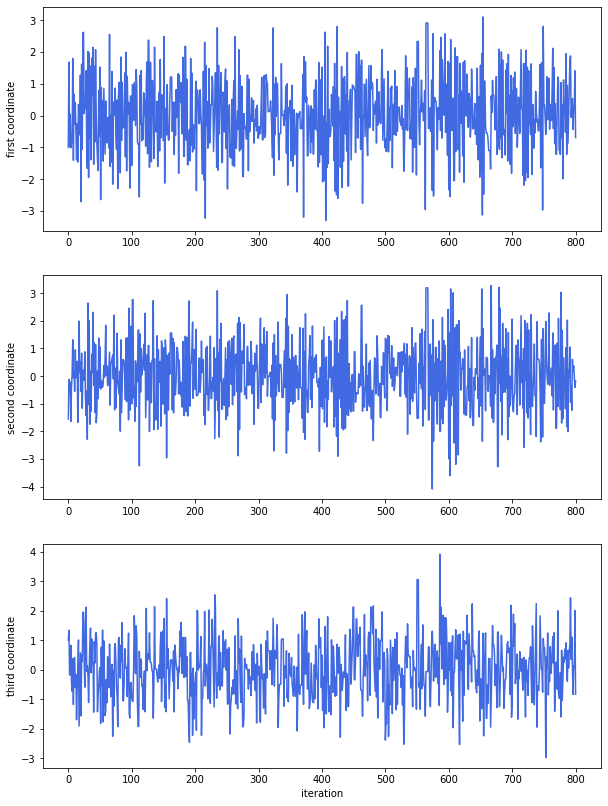

In [5]:
samples,_ = HMC(15,0.40,μ,Σ,grad_U,U,np.array([-1,-1.55,1.0]))
print("Acceptance rate of {}%".format(_*100))
fig3, axes = plt.subplots(3,figsize=(10,14))
axes[0].plot(range(samples.shape[0]), samples[:,0],color="royalblue");
axes[0].set_ylabel('first coordinate')
axes[1].plot(range(samples.shape[0]), samples[:,1],color="royalblue");
axes[1].set_ylabel('second coordinate')
axes[2].plot(range(samples.shape[0]), samples[:,2], color="royalblue");
axes[2].set_ylabel('third coordinate');
axes[2].set_xlabel('iteration');

In [6]:
def plot(samples):
    fig = plt.figure(figsize=(10,10))
    ax1=plt.subplot2grid( (3,3), [0,0], 1, 1 )
    sns.histplot(data=Y,x="x_1",ax=ax1,color='black',alpha=0.4,label='True values')
    sns.histplot(data=samples,x="x_1",color='royalblue',ax=ax1,alpha=0.6,label='Sampled values')
    ax1.set_xlabel('')
    #ax1.legend()
    ax2=plt.subplot2grid( (3,3), [1,0], 1, 1 )
    sns.kdeplot(data=Y,x='x_1',y='x_2',ax=ax2,color='black',alpha=0.6)
    sns.scatterplot(data=samples,x='x_1',y='x_2',ax=ax2,color='royalblue',linewidth=0.25)
    ax2.set_xlabel('')
    #plt.plot( x2, y2 )
    #plt.subplot2grid( (3,3), [1,0], 1, 1 )
    ax3=plt.subplot2grid( (3,3), [1,1], 1, 1 )
    sns.histplot(data=Y,x="x_2",ax=ax3,color='black',alpha=0.4)
    sns.histplot(data=samples,x="x_2",color='royalblue',ax=ax3,alpha=0.6)
    ax3.set_ylabel('')
    ax3.set_xlabel('')
    ax4=plt.subplot2grid( (3,3), [2,0], 1, 1 )
    sns.kdeplot(data=Y,x='x_1',y='x_3',ax=ax4,color='black',alpha=0.6)
    sns.scatterplot(data=samples,x='x_1',y='x_3',ax=ax4,color='royalblue',linewidth=0.25)
    ax5=plt.subplot2grid( (3,3), [2,1], 1, 1 )
    sns.kdeplot(data=Y,x='x_2',y='x_3',ax=ax5,color='black',alpha=0.6)
    sns.scatterplot(data=samples,x='x_2',y='x_3',ax=ax5,color='royalblue',linewidth=0.25)
    ax5.set_ylabel('')
    ax6=plt.subplot2grid( (3,3), [2,2], 1, 1 )
    sns.histplot(data=Y,x="x_3",ax=ax6,color='black',alpha=0.4)
    sns.histplot(data=samples,x="x_3",color='royalblue',ax=ax6,alpha=0.6,linewidth=1)
    ax6.set_ylabel('')
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels,loc='center right',bbox_to_anchor=[0.82,0.59]);
    return fig

## Comparison of HMC samples to samples which were directly drawn from the target distribution 

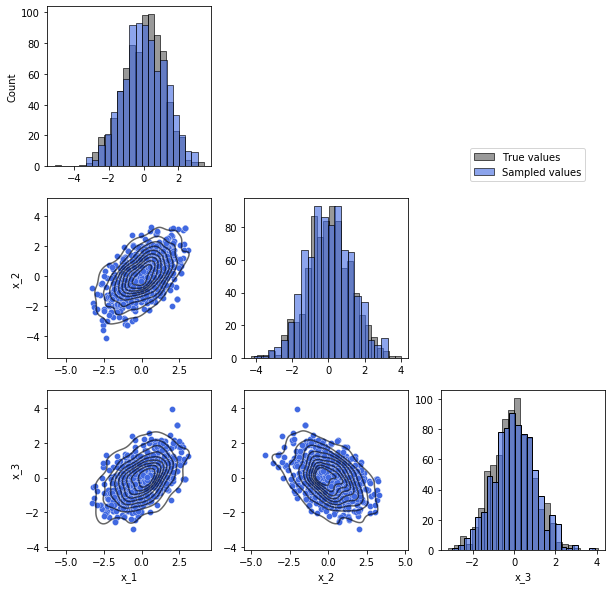

In [7]:
samples_df = pd.DataFrame(samples,columns=['x_1','x_2','x_3'])
fig4 = plot(samples_df)

## RWMH algorithm

In [8]:
init = np.array([-1,-1.55,1.0])
n= 800
MCMC = [init]
s = init
accepted = 0
for i in range(n):
    s = MCMC[-1]
    #generate proposal sample
    y = np.random.multivariate_normal(s,1.0*np.eye(3))
    #compute acceptance rate
    α = f(y,μ,Σ)/f(s,μ,Σ)
    #accepte or reject
    if α > np.random.uniform(0,1):
        #if accepted append proposal sample to list of samples
        MCMC.append(y)
        accepted +=1
    else:
        #if rejected append current state to list of samples
        MCMC.append(s)
print("Acceptance rate of {}%".format(accepted/n*100))

Acceptance rate of 22.625%


In [9]:
samples_hm = pd.DataFrame(np.asarray(MCMC),columns=['x_1','x_2','x_3'])

## Autocorrelation of RWMH and HMC samples

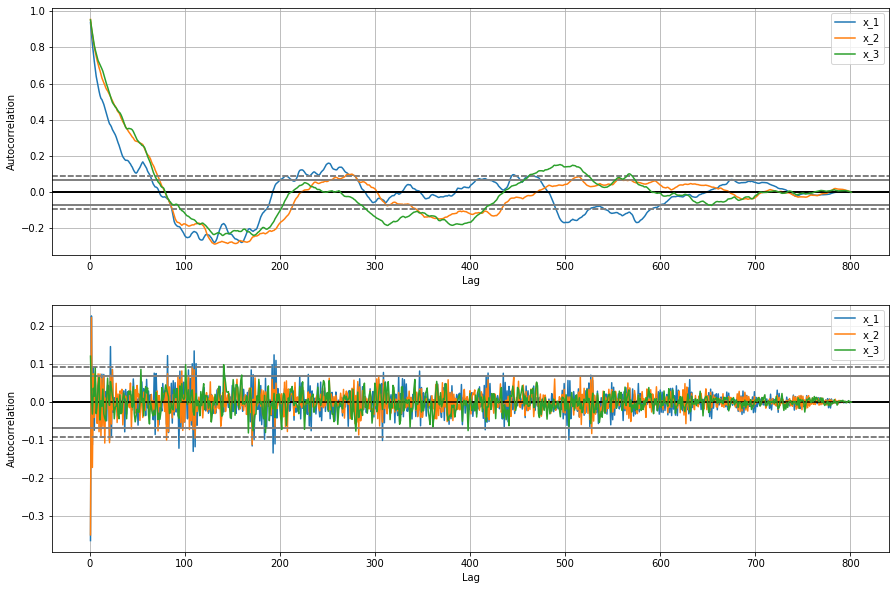

In [10]:
fig3 ,ax = plt.subplots(2,figsize=(15,10))
for variable in samples_hm.columns:
    pd.plotting.autocorrelation_plot(samples_hm[variable], label = variable,ax=ax[0])
for variable in samples_df.columns:
    pd.plotting.autocorrelation_plot(samples_df[variable], label = variable,ax=ax[1])